# SmallPebble

[![](https://github.com/sradc/smallpebble/workflows/Python%20package/badge.svg)](https://github.com/sradc/smallpebble/commits/) 

SmallPebble is a minimalist autodiff and deep learning library written from scratch in Python.
It runs automatic differentiation on NumPy arrays.

**The core implementation is in a single file: [smallpebble.py](https://github.com/sradc/SmallPebble/blob/master/smallpebble/smallpebble.py)**

**The only dependency of the core implementation is NumPy.**

SmallPebble demonstrates the key concepts under the hood of deep learning frameworks,
without the complexity of performance optimizations or GPU support.

### Recommended Learning Path:
- Read [this](https://sidsite.com/posts/autodiff/) introduction to autodiff, by the author.
    - It presents a similar autodiff implementation to SmallPebble, but simplified, on scalars.
- Read the source code: [smallpebble.py](https://github.com/sradc/SmallPebble/blob/master/smallpebble/smallpebble.py).
- Take a look at the `tests/` folder — this library was written test-first.
- Clone the repo and play with it...

### Installation
Clone the repository and install it locally:
```bash
git clone https://github.com/sradc/smallpebble.git
cd smallpebble

# Install core library
pip install .

# Or, to run the examples/notebooks
pip install ".[examples]"
```

### Highlights
- **Compact:** < 1000 lines of core logic.
- **Feature-rich:** Supports matmul, conv2d, maxpool2d, and array broadcasting.
- **Flexible:** Supports eager execution and implicit graph building.
- **Extensible:** Easy API for adding custom operations.

### How it works (TL;DR)
SmallPebble builds **dynamic computation graphs** implicitly via Python object referencing (similar to PyTorch). 
When `get_gradients` is called, autodiff is performed by traversing the graph backward.

### Read on to see:
- Example models created and trained using SmallPebble.
- A brief guide to using the library.

_This README is generated from [README.ipynb](https://github.com/sradc/SmallPebble/blob/master/README.ipynb)._

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import smallpebble as sp
from smallpebble.datasets import load_data

## Training a neural network to classify handwritten digits (MNIST)

In [2]:
"Load the dataset, and create a validation set."

X_train, y_train, _, _ = load_data('mnist')  # load / download from openml.org
X_train = X_train/255  # normalize

# Seperate out data for validation.
X = X_train[:50_000, ...]
y = y_train[:50_000]
X_eval = X_train[50_000:60_000, ...]
y_eval = y_train[50_000:60_000]

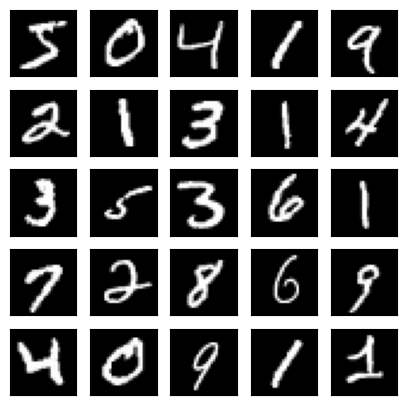

In [3]:
"Plot, to check we have the right data."

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:].reshape(28,28), cmap='gray', vmin=0, vmax=1)

plt.show()

In [4]:
"Create a model, with two fully connected hidden layers."

X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = sp.linearlayer(28*28, 100)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 100)(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 10)(h)
y_pred = sp.Lazy(sp.softmax)(h)
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

  0%|          | 0/300 [00:00<?, ?it/s]

Final validation accuracy: 0.932


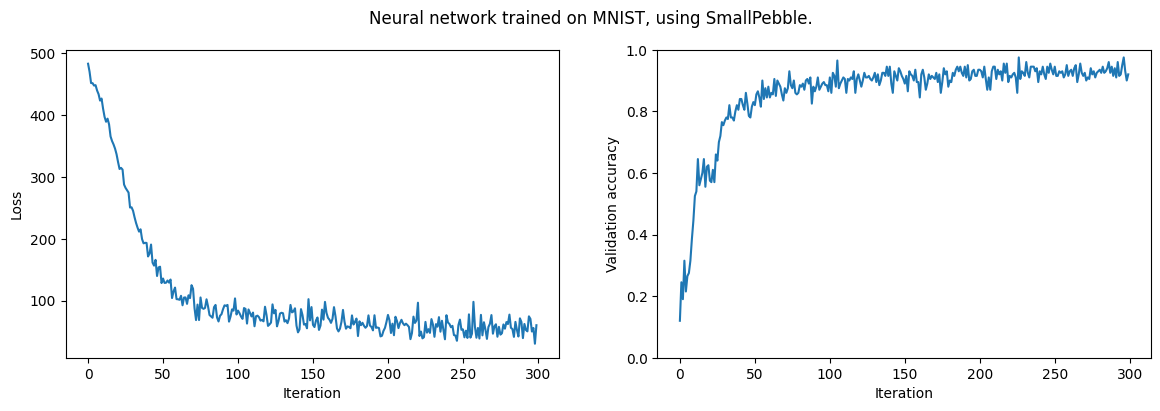

In [5]:
"Train model, while measuring performance on the validation dataset."

NUM_ITERS = 300
BATCH_SIZE = 200

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)
adam = sp.Adam()  # Adam optimization

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_ITERS):
    if i >= NUM_ITERS: break
    
    X_in.assign_value(sp.Variable(xbatch))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()  # run the graph
    if np.isnan(loss_val.array):
        print("loss is nan, aborting.")
        break
    loss_vals.append(loss_val.array)
        
    # Compute gradients, and use to carry out learning step:
    gradients = sp.get_gradients(loss_val)
    adam.training_step(learnables, gradients)
        
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

# Plot results:
print(f'Final validation accuracy: {np.mean(validation_acc[-10:])}')
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.suptitle('Neural network trained on MNIST, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

## Training a convolutional neural network on a CIFAR-10 subset

Use a subset of the data because this runs on CPU.


In [6]:
"Load the CIFAR dataset."

X_train, y_train, _, _ = load_data('cifar')  # load/download from openml.org
X_train = X_train/255  # normalize

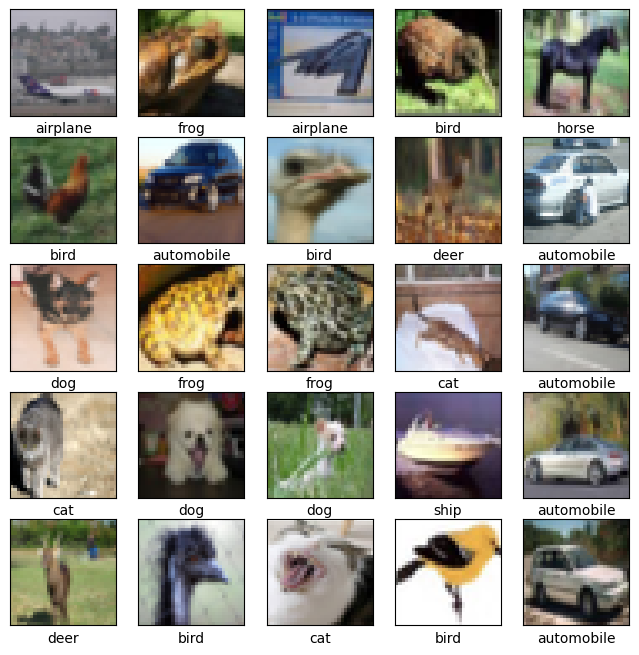

In [7]:
"""Plot, to check it's the right data.

(This cell's code is from: https://www.tensorflow.org/tutorials/images/cnn#verify_the_data)
"""

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:].reshape(32,32,3))
    plt.xlabel(class_names[y_train[i]])

plt.show()

In [8]:
# Seperate out data for validation as before.
X = X_train[:1000, ...]
y = y_train[:1000]
X_eval = X_train[1000:1100, ...]
y_eval = y_train[1000:1100]

In [9]:
"""Define a model."""

X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = sp.convlayer(height=3, width=3, depth=3, n_kernels=32)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.convlayer(3, 3, 32, 128, padding='VALID')(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.convlayer(3, 3, 128, 128, padding='VALID')(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.Lazy(lambda x: sp.reshape(x, [-1, 3*3*128]))(h)
h = sp.linearlayer(3*3*128, 10)(h)
h = sp.Lazy(sp.softmax)(h)

y_pred = h
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

# Check we get the expected dimensions
X_in.assign_value(sp.Variable(X[0:3, :].reshape([-1, 32, 32, 3])))
h.run().shape

(3, 10)

Train the model.

  0%|          | 0/100 [00:00<?, ?it/s]

Final validation accuracy: 0.3109375


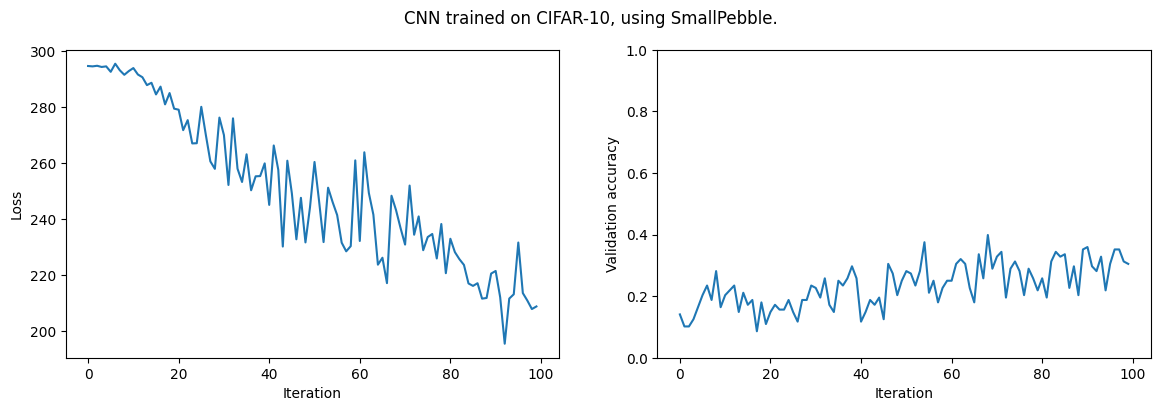

In [10]:
NUM_ITERS = 100
BATCH_SIZE = 128

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)
adam = sp.Adam()

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_ITERS):
    if i >= NUM_ITERS: break
       
    xbatch_images = xbatch.reshape([-1, 32, 32, 3])
    X_in.assign_value(sp.Variable(xbatch_images))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()
    if np.isnan(loss_val.array):
        print("Aborting, loss is nan.")
        break
    loss_vals.append(loss_val.array)
    
    # Compute gradients, and carry out learning step.
    gradients = sp.get_gradients(loss_val)  
    adam.training_step(learnables, gradients)
    
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch.reshape([-1, 32, 32, 3])))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

print(f'Final validation accuracy: {np.mean(validation_acc[-10:])}')
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.suptitle('CNN trained on CIFAR-10, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

We could improve our results by training for longer, but note we are limited by the speed of CPU.

---

# Brief guide to using SmallPebble

SmallPebble provides the following building blocks to make models with:

- `sp.Variable`
- Operations, such as `sp.add`, `sp.mul`, etc.
- `sp.get_gradients`
- `sp.Lazy`
- `sp.Placeholder` (this is really just `sp.Lazy` on the identity function)
- `sp.learnable`
- `sp.get_learnables`

The following examples show how these are used.


## sp.Variable & sp.get_gradients 

With SmallPebble, you can:

- Wrap NumPy arrays in `sp.Variable`
- Apply SmallPebble operations (e.g. `sp.matmul`, `sp.add`, etc.)
- Compute gradients with `sp.get_gradients`

In [11]:
a = sp.Variable(np.random.random([2, 2]))
b = sp.Variable(np.random.random([2, 2]))
c = sp.Variable(np.random.random([2]))
y = sp.mul(a, b) + c
print('y.array:\n', y.array)

gradients = sp.get_gradients(y)
grad_a = gradients[a]
grad_b = gradients[b]
grad_c = gradients[c]
print('grad_a:\n', grad_a)
print('grad_b:\n', grad_b)
print('grad_c:\n', grad_c)

y.array:
 [[1.02460932 0.76807643]
 [1.27444666 0.59825055]]
grad_a:
 [[0.68886369 0.86822053]
 [0.65274075 0.58280287]]
grad_b:
 [[0.47640529 0.28786036]
 [0.88552101 0.13743994]]
grad_c:
 [2. 2.]


Note that `y` is computed straight away, i.e. the (forward) computation happens immediately.

Also note that `y` is a sp.Variable and we could continue to carry out SmallPebble operations on it.

## sp.Lazy & sp.Placeholder

Lazy graphs are constructed using `sp.Lazy` and `sp.Placeholder`. 

In [12]:
lazy_node = sp.Lazy(lambda a, b: a + b)(1, 2)
print(lazy_node)
print(lazy_node.run())

3


In [13]:
a = sp.Lazy(lambda a: a)(2)
y = sp.Lazy(lambda a, b, c: a * b + c)(a, 3, 4)
print(y)
print(y.run())

10


Forward computation does not happen immediately - only when .run() is called.

In [14]:
a = sp.Placeholder()
b = sp.Variable(np.random.random([2, 2]))
y = sp.Lazy(sp.matmul)(a, b)

a.assign_value(sp.Variable(np.array([[1,2], [3,4]])))

result = y.run()
print('result.array:\n', result.array)

result.array:
 [[2.53093351 0.90162336]
 [5.61788051 1.97511828]]


You can use .run() as many times as you like. 

Let's change the placeholder value and re-run the graph:

In [15]:
a.assign_value(sp.Variable(np.array([[10,20], [30,40]])))
result = y.run()
print('result.array:\n', result.array)

result.array:
 [[25.30933514  9.01623359]
 [56.17880514 19.75118278]]


Finally, let's compute gradients:

In [16]:
gradients = sp.get_gradients(result)

Note that `sp.get_gradients` is called on `result`, 
which is a `sp.Variable`, 
not on `y`, which is a `sp.Lazy` instance.

## sp.learnable & sp.get_learnables
Use `sp.learnable` to flag parameters as learnable, 
allowing them to be extracted from a lazy graph with `sp.get_learnables`.

This enables a workflow of: building a model, while flagging parameters as learnable, and then extracting all the parameters in one go at the end.


In [17]:
a = sp.Placeholder()
b = sp.learnable(sp.Variable(np.random.random([2, 1])))
y = sp.Lazy(sp.matmul)(a, b)
y = sp.Lazy(sp.add)(y, sp.learnable(sp.Variable(np.array([5]))))

learnables = sp.get_learnables(y)

for learnable in learnables:
    print(learnable)